In [1]:
# 引入所需要的全部包
from sklearn.model_selection import train_test_split # 数据划分的类
from sklearn.linear_model import LinearRegression # 线性回归的类
from sklearn.preprocessing import StandardScaler # 数据标准化

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import time

In [2]:
## 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']
mpl.rcParams['axes.unicode_minus']=False

In [3]:
# 加载数据
# 日期、时间、有功功率、无功功率、电压、电流、厨房用电功率、洗衣服用电功率、热水器用电功率
path1='datas/household_power_consumption_1000.txt'
df = pd.read_csv(path1, sep=';', low_memory=False)#没有混合类型的时候可以通过low_memory=F调用更多内存，加快效率）

In [4]:
df.head() ## 获取前五行数据查看查看

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
# 查看格式信息
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   1000 non-null   object 
 1   Time                   1000 non-null   object 
 2   Global_active_power    1000 non-null   float64
 3   Global_reactive_power  1000 non-null   float64
 4   Voltage                1000 non-null   float64
 5   Global_intensity       1000 non-null   float64
 6   Sub_metering_1         1000 non-null   float64
 7   Sub_metering_2         1000 non-null   float64
 8   Sub_metering_3         1000 non-null   float64
dtypes: float64(7), object(2)
memory usage: 70.4+ KB


In [6]:
# 异常数据处理(异常数据过滤)
new_df = df.replace('?', np.nan)#替换非法字符为np.nan
datas = new_df.dropna(axis=0, how = 'any') # 只要有一个数据为空，就进行行删除操作
datas.describe().T#观察数据的多种统计指标(只能看数值型的)

,count,mean,std,min,25%,50%,75%,max
Global_active_power,1000.0,2.418772,1.239979,0.206,1.806,2.414,3.308,7.706
Global_reactive_power,1000.0,0.089232,0.088088,0.000,0.000,0.072,0.126,0.528
Voltage,1000.0,240.035790,4.084420,230.980,236.940,240.650,243.295,249.370
Global_intensity,1000.0,10.351000,5.122214,0.800,8.400,10.000,14.000,33.200
Sub_metering_1,1000.0,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000
Sub_metering_2,1000.0,2.749000,8.104053,0.000,0.000,0.000,1.000,38.000
Sub_metering_3,1000.0,5.756000,8.066941,0.000,0.000,0.000,17.000,19.000


In [7]:
# 查看格式信息
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   1000 non-null   object 
 1   Time                   1000 non-null   object 
 2   Global_active_power    1000 non-null   float64
 3   Global_reactive_power  1000 non-null   float64
 4   Voltage                1000 non-null   float64
 5   Global_intensity       1000 non-null   float64
 6   Sub_metering_1         1000 non-null   float64
 7   Sub_metering_2         1000 non-null   float64
 8   Sub_metering_3         1000 non-null   float64
dtypes: float64(7), object(2)
memory usage: 70.4+ KB


In [8]:
## 创建一个时间函数格式化字符串
def date_format(dt):
    # dt显示是一个series/tuple；dt[0]是date，dt[1]是time
    import time
    t = time.strptime(' '.join(dt), '%d/%m/%Y %H:%M:%S')
    return (t.tm_year, t.tm_mon, t.tm_mday, t.tm_hour, t.tm_min, t.tm_sec)

In [9]:
## 需求：构建时间和功率之间的映射关系，可以认为：特征属性为时间；目标属性为功率值。
# 获取x和y变量, 并将时间转换为数值型连续变量
X = datas.iloc[:,0:2]
X = X.apply(lambda x: pd.Series(date_format(x)), axis=1)
Y = datas['Global_active_power']

In [10]:
X.head(2)

,0,1,2,3,4,5
0,2006,12,16,17,24,0
1,2006,12,16,17,25,0


In [11]:
## 对数据集进行测试集合训练集划分
# X：特征矩阵(类型一般是DataFrame)
# Y：特征对应的Label标签(类型一般是Series)
# test_size: 对X/Y进行划分的时候，测试集合的数据占比, 是一个(0,1)之间的float类型的值
# random_state: 数据分割是基于随机器进行分割的，该参数给定随机数种子；给一个值(int类型)的作用就是保证每次分割所产生的数数据集是完全相同的
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [12]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(800, 6)
(200, 6)
(800,)


In [13]:
# 查看训练集上的数据信息(X)
X_train.describe()

,0,1,2,3,4,5
count,800.0,800.0,800.000000,800.000000,800.000000,800.0
mean,2006.0,12.0,16.598750,10.755000,29.723750,0.0
std,0.0,0.0,0.490458,8.068386,17.266517,0.0
min,2006.0,12.0,16.000000,0.000000,0.000000,0.0
25%,2006.0,12.0,16.000000,4.000000,15.000000,0.0
50%,2006.0,12.0,17.000000,8.000000,30.000000,0.0
75%,2006.0,12.0,17.000000,19.000000,45.000000,0.0
max,2006.0,12.0,17.000000,23.000000,59.000000,0.0


In [14]:
## 数据标准化
# StandardScaler：将数据转换为标准差为1的数据集(有一个数据的映射)
# scikit-learn中：如果一个API名字有fit，那么就有模型训练的含义，没法返回值
# scikit-learn中：如果一个API名字中有transform， 那么就表示对数据具有转换的含义操作
# scikit-learn中：如果一个API名字中有predict，那么就表示进行数据预测，会有一个预测结果输出
# scikit-learn中：如果一个API名字中既有fit又有transform的情况下，那就是两者的结合(先做fit，再做transform)
ss = StandardScaler() # 模型对象创建
X_train = ss.fit_transform(X_train) # 训练模型并转换训练集
X_test = ss.transform(X_test) ## 直接使用在模型构建数据上进行一个数据标准化操作 (测试集)

In [15]:
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5
count,800.0,800.0,8.000000e+02,8.000000e+02,8.000000e+02,800.0
mean,0.0,0.0,2.069456e-15,-5.107026e-17,5.329071e-17,0.0
std,0.0,0.0,1.000626e+00,1.000626e+00,1.000626e+00,0.0
min,0.0,0.0,-1.221561e+00,-1.333814e+00,-1.722545e+00,0.0
25%,0.0,0.0,-1.221561e+00,-8.377420e-01,-8.532677e-01,0.0
50%,0.0,0.0,8.186245e-01,-3.416698e-01,1.600918e-02,0.0
75%,0.0,0.0,8.186245e-01,1.022529e+00,8.852861e-01,0.0
max,0.0,0.0,8.186245e-01,1.518601e+00,1.696611e+00,0.0


In [16]:
## 模型训练
lr = LinearRegression(fit_intercept=True) # 模型对象构建
lr.fit(X_train, Y_train) ## 训练模型
## 模型校验
y_predict = lr.predict(X_test) ## 预测结果

print("训练集上R2:",lr.score(X_train, Y_train))
print("测试集上R2:",lr.score(X_test, Y_test))
mse = np.average((y_predict-Y_test)**2)
rmse = np.sqrt(mse)
print("rmse:",rmse)

训练集上R2: 0.24409311805909029
测试集上R2: 0.12551628513735846
rmse: 1.164092345973625


In [17]:
# 输出模型训练得到的相关参数
print("模型的系数(θ):", end="")
print(lr.coef_)
print("模型的截距:", end='')
print(lr.intercept_)

模型的系数(θ):[ 0.00000000e+00 -6.66133815e-16 -1.41588166e+00 -9.34953243e-01
 -1.02140756e-01  0.00000000e+00]
模型的截距:2.4454375000000033


In [24]:
## 模型保存/持久化
# 在机器学习部署的时候，实际上其中一种方式就是将模型进行输出；另外一种方式就是直接将预测结果输出
# 模型输出一般是将模型输出到磁盘文件
import joblib

# 保存模型要求给定的文件所在的文件夹比较存在
joblib.dump(ss, "result/data_ss.model") ## 将标准化模型保存
joblib.dump(lr, "result/data_lr.model") ## 将模型保存

['result/data_lr.model']

In [25]:
# 加载模型
ss3 = joblib.load("result/data_ss.model") ## 加载模型
lr3 = joblib.load("result/data_lr.model") ## 加载模型

# 使用加载的模型进行预测
data1 = [[2006, 12, 17, 12, 25, 0]]
data1 = ss3.transform(data1)
print(data1)
lr3.predict(data1)

[[ 0.          0.          0.81862454  0.15440249 -0.27374978  0.        ]]


array([1.16996393])

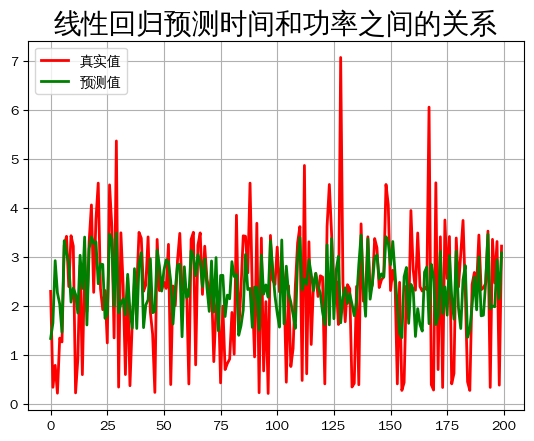

In [28]:
## 预测值和实际值画图比较
t=np.arange(len(X_test))
plt.figure(facecolor='w')#建一个画布，facecolor是背景色
plt.plot(t, Y_test, 'r-', linewidth=2, label='真实值')
plt.plot(t, y_predict, 'g-', linewidth=2, label='预测值')
plt.legend(loc = 'upper left')#显示图例，设置图例的位置
plt.title("线性回归预测时间和功率之间的关系", fontsize=20)
plt.grid(True)#加网格
plt.show()

电流预测准确率:  0.9920420609708968
电流参数: [5.07744316 0.07191391]


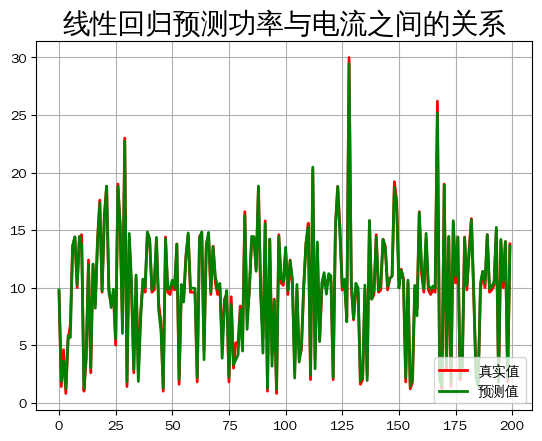

In [30]:
## 功率和电流之间的关系
X = datas.iloc[:,2:4]
Y2 = datas.iloc[:,5]

## 数据分割
X2_train,X2_test,Y2_train,Y2_test = train_test_split(X, Y2, test_size=0.2, random_state=0)

## 数据归一化
scaler2 = StandardScaler()
X2_train = scaler2.fit_transform(X2_train) # 训练并转换
X2_test = scaler2.transform(X2_test) ## 直接使用在模型构建数据上进行一个数据标准化操作 

## 模型训练
lr2 = LinearRegression()
lr2.fit(X2_train, Y2_train) ## 训练模型

## 结果预测
Y2_predict = lr2.predict(X2_test)

## 模型评估
print("电流预测准确率: ", lr2.score(X2_test,Y2_test))
print("电流参数:", lr2.coef_)

## 绘制图表
#### 电流关系
t=np.arange(len(X2_test))
plt.figure(facecolor='w')
plt.plot(t, Y2_test, 'r-', linewidth=2, label=u'真实值')
plt.plot(t, Y2_predict, 'g-', linewidth=2, label=u'预测值')
plt.legend(loc = 'lower right')
plt.title(u"线性回归预测功率与电流之间的关系", fontsize=20)
plt.grid(True)
plt.show()